Head of data:
   duration  event  age   bmi  treatment  blood_pressure
0      5.25      1   58  27.1          1             140
1     10.88      1   71  40.4          0             111
2     76.03      1   48  27.3          1             121
3     25.21      1   34  29.5          0             148
4      9.64      1   62  28.8          1             175

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   duration        500 non-null    float64
 1   event           500 non-null    int64  
 2   age             500 non-null    int64  
 3   bmi             500 non-null    float64
 4   treatment       500 non-null    int64  
 5   blood_pressure  500 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 23.6 KB
None

Scaled training head:
        age       bmi  treatment  blood_pressure  duration  event
0 -1.749910  0.051541       

  0%|          | 0/100 [00:00<?, ?it/s]

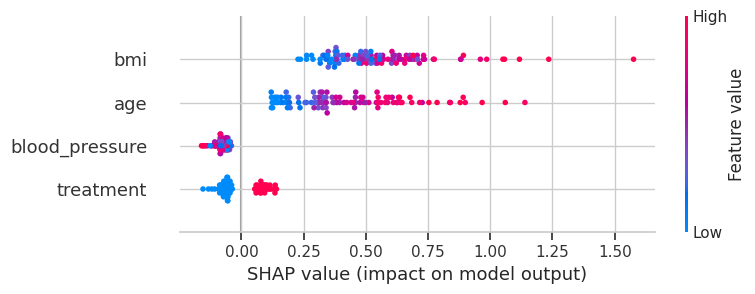

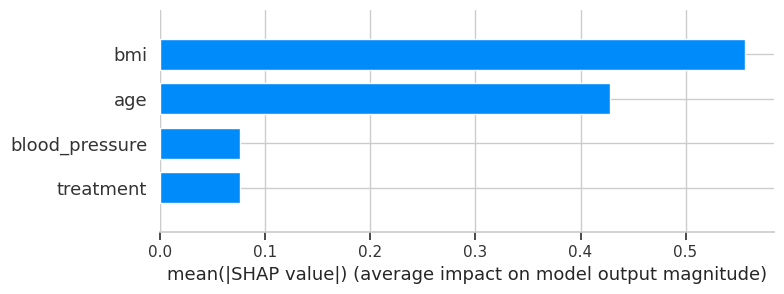

  0%|          | 0/1 [00:00<?, ?it/s]


Instance to explain:
     age   bmi  treatment  blood_pressure
371   27  29.6          0             153
Waterfall plot not available in this SHAP version: waterfall_legacy() got an unexpected keyword argument 'feature_values'

Risk group counts:
risk_group
Low       167
High      167
Medium    166
Name: count, dtype: int64


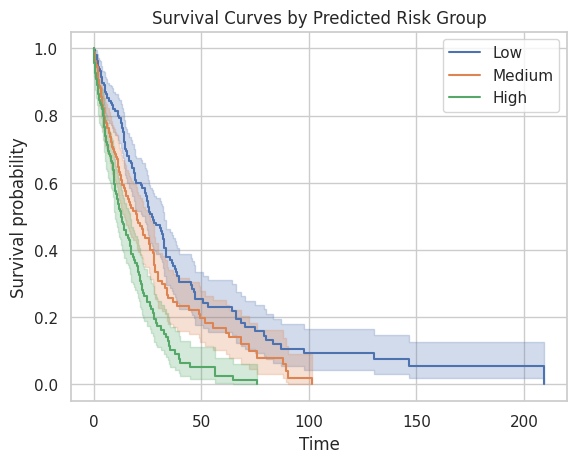

In [6]:
# ============================================
# 1. Imports
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install lifelines shap -q

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ============================================
# 2. Load dataset
#    (Upload survival_dataset.csv to your env)
# ============================================
# If in Colab, first do: from google.colab import files; files.upload()
df = pd.read_csv("/content/survival_dataset.csv")

print("Head of data:")
print(df.head())
print("\nInfo:")
print(df.info())

# duration : time to event / censoring
# event    : 1 = event occurred, 0 = censored

# ============================================
# 3. Train / test split
# ============================================
features = ["age", "bmi", "treatment", "blood_pressure"]
target_time = "duration"
target_event = "event"

X = df[features]
y_time = df[target_time]
y_event = df[target_event]

X_train, X_test, y_time_train, y_time_test, y_event_train, y_event_test = train_test_split(
    X, y_time, y_event, test_size=0.2, random_state=42, stratify=y_event
)

# Combine back into DataFrame for lifelines Cox model
train_df = pd.concat(
    [X_train.reset_index(drop=True),
     y_time_train.reset_index(drop=True),
     y_event_train.reset_index(drop=True)],
    axis=1,
)
test_df = pd.concat(
    [X_test.reset_index(drop=True),
     y_time_test.reset_index(drop=True),
     y_event_test.reset_index(drop=True)],
    axis=1,
)

# ============================================
# 4. (Optional) Scale numerical features
#    Cox works better when features are on similar scales
# ============================================
num_cols = ["age", "bmi", "blood_pressure"]
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

print("\nScaled training head:")
print(train_df.head())

# ============================================
# 5. Fit regularized Cox Proportional Hazards model
# ============================================
cph = CoxPHFitter(penalizer=0.1)  # L2 penalty to stabilize estimates
cph.fit(train_df, duration_col=target_time, event_col=target_event)

print("\nCox model summary:")
print(cph.summary)

# ============================================
# 6. Model performance: Concordance Index
# ============================================
# Partial hazard (risk score) on test data
test_risk = cph.predict_partial_hazard(test_df)

c_index = concordance_index(
    event_times=y_time_test,
    predicted_scores=-test_risk.values.flatten(),  # negative because higher risk -> shorter survival
    event_observed=y_event_test
)
print(f"\nConcordance Index on test set: {c_index:.3f}")

# ============================================
# 7. Global SHAP analysis (KernelExplainer)
#    We treat predict_partial_hazard as black-box model
# ============================================

# SHAP can be slow on large data – use a small background sample
background = train_df[features].sample(n=min(100, len(train_df)), random_state=42)

# Model function for SHAP
def model_predict(X_array):
    # X_array is numpy array; convert to DataFrame with column names
    X_df = pd.DataFrame(X_array, columns=features)
    # Need to apply same scaling as training
    X_df[num_cols] = scaler.transform(X_df[num_cols])
    # Put dummy duration and event columns (not used for prediction)
    temp = X_df.copy()
    temp[target_time] = train_df[target_time].median()
    temp[target_event] = 1
    # Predict partial hazard (risk)
    return cph.predict_partial_hazard(temp).values

# Background for KernelExplainer
background_array = background.values

explainer = shap.KernelExplainer(model_predict, background_array)

# Take subset of test set for SHAP (for speed)
X_test_sample = X_test.sample(n=min(100, len(X_test)), random_state=0)
X_test_sample_array = X_test_sample.values

# Compute SHAP values
shap_values = explainer.shap_values(X_test_sample_array)

# ============================================
# 8. SHAP Global Plots
# ============================================
shap.initjs()

# Summary beeswarm plot
shap.summary_plot(shap_values, X_test_sample, feature_names=features)

# Bar plot of mean |SHAP| values (feature importance)
shap.summary_plot(shap_values, X_test_sample, feature_names=features, plot_type="bar")

# ============================================
# 9. Local explanation for a single individual
# ============================================
# Choose one row from test sample
idx = 0
x_instance = X_test_sample.iloc[idx:idx+1]
x_instance_array = x_instance.values

# SHAP values for this instance
shap_values_instance = explainer.shap_values(x_instance_array)

print("\nInstance to explain:")
print(x_instance)

# Waterfall plot (requires shap.plots._waterfall.waterfall_plot in some versions)
try:
    shap.plots._waterfall.waterfall_legacy(
        shap_values_instance[0],
        feature_names=features,
        feature_values=x_instance_array[0]
    )
except Exception as e:
    print("Waterfall plot not available in this SHAP version:", e)

# ============================================
# 10. Risk stratification + Survival curves (optional for report)
# ============================================

# Add predicted risk to full dataset
full_df = df.copy()
full_df[num_cols] = scaler.transform(full_df[num_cols])
full_df[target_time] = df[target_time]
full_df[target_event] = df[target_event]

risk_scores = cph.predict_partial_hazard(full_df).values.flatten()
full_df["risk_score"] = risk_scores

# Create risk groups (low, medium, high)
full_df["risk_group"] = pd.qcut(full_df["risk_score"], q=3, labels=["Low", "Medium", "High"])

print("\nRisk group counts:")
print(full_df["risk_group"].value_counts())

# Plot Kaplan-Meier curves by risk group
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

plt.figure()
for group in ["Low", "Medium", "High"]:
    mask = full_df["risk_group"] == group
    kmf.fit(full_df.loc[mask, target_time],
            full_df.loc[mask, target_event],
            label=group)
    kmf.plot_survival_function()

plt.title("Survival Curves by Predicted Risk Group")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.show()